In [1]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [2]:
# make deterministic
from mingpt.utils import set_seed
set_seed(42)

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In [4]:
# config
embeddingSize=512
numPoints=200 # number of points that we are going to receive to make a prediction about f given x and y
numVars=2 # the dimenstion of input points x
numYs=1 # the dimension of output points y = f(x)
blockSize = 100 # spatial extent of the model for its context
batchSize = 128
dataInfo = 'XYE_{}Var_{}Points'.format(numVars, numPoints)
target = 'Skeleton' #'EQ'
dataFolder = '2Var_Rand_FixedLength_0to3_3.1to6'

In [5]:
import math
from torch.utils.data import Dataset

class CharDataset(Dataset):

    def __init__(self, data, block_size, chars, target='EQ'):
        data_size, vocab_size = len(data), len(chars)
        print('data has %d examples, %d unique.' % (data_size, vocab_size))
        
        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
        
        # padding token
        self.paddingToken = '_'
        self.paddingID = self.stoi[self.paddingToken]
        self.stoi[self.paddingToken] = self.paddingID
        self.itos[self.paddingID] = self.paddingToken
        self.threshold = [-1000,1000]
        
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data # it should be a list of examples
        self.target = target
    
    def __len__(self):
        return len(self.data)-1

    def __getitem__(self, idx):
        # grab an example from the data
        chunk = self.data[idx] # sequence of tokens including x, y, eq, etc.
        
        try:
            chunk = json.loads(chunk) # convert the sequence tokens to a dictionary
        except:
            print("Couldn't convert to json: {}".format(chunk))
            
        # encode every character in the equation to an integer
        # < is SOS, > is EOS
        dix = [self.stoi[s] for s in '<'+chunk[self.target]+'>']
        inputs = dix[:-1]
        outputs = dix[1:]
        
        # add the padding to the equations
        paddingSize = max(self.block_size-len(inputs),0)
        paddingList = [self.paddingID]*paddingSize
        inputs += paddingList
        outputs += paddingList 
        
        # make sure it is not more than what should be
        inputs = inputs[:self.block_size]
        outputs = outputs[:self.block_size]
        
        # extract points from the input sequence
        points = torch.zeros(numVars+numYs, numPoints)
        for idx, xy in enumerate(zip(chunk['X'], chunk['Y'])):
            x = xy[0] + [0]*(max(numVars-len(xy[0]),0)) # padding
            y = [xy[1]] if type(xy[1])== float else xy[1]
            y = y + [0]*(max(numYs-len(y),0)) # padding
            p = x+y # because it is only one point 
            p = torch.tensor(p)
            #replace nan and inf
            p = torch.nan_to_num(p, nan=0.0, 
                                 posinf=self.threshold[1], 
                                 neginf=self.threshold[0])
            p[p>self.threshold[1]] = self.threshold[1] # clip the upper bound
            p[p<self.threshold[0]] = self.threshold[0] # clip the lower bound
            points[:,idx] = p
        
        """
        arrange data and targets so that the first i elements of x
        will be asked to predict the i-th element of y. Notice that
        the eventual language model will actually make block_size
        individual predictions at the same time based on this data,
        so we are being clever and amortizing the cost of the forward
        pass of the network. So for example if block_size is 4, then
        we could e.g. sample a chunk of text "hello", the integers in
        x will correspond to "hell" and in y will be "ello". This will
        then actually "multitask" 4 separate examples at the same time
        in the language model:
        - given just "h", please predict "e" as next
        - given "he" please predict "l" next
        - given "hel" predict "l" next
        - given "hell" predict "o" next
        
        In addition, because the DataLoader will create batches of examples,
        every forward/backward pass during traning will simultaneously train
        a LOT of predictions, amortizing a lot of computation. In particular,
        for a batched input of integers X (B, T) where B is batch size and
        T is block_size and Y (B, T), the network will during training be
        simultaneously training to make B*T predictions, all at once! Of course,
        at test time we can paralellize across batch B, but unlike during training
        we cannot parallelize across the time dimension T - we have to run
        a forward pass of the network to recover the next single character of the 
        sequence along each batch dimension, and repeatedly always feed in a next
        character to get the next one.
        
        So yes there is a big asymmetry between train/test time of autoregressive
        models. During training we can go B*T at a time with every forward pass,
        but during test time we can only go B at a time, T times, with T forward 
        passes.
        """
        inputs = torch.tensor(inputs, dtype=torch.long)
        outputs = torch.tensor(outputs, dtype=torch.long)
        return inputs, outputs, points


In [6]:
import json
from tqdm import tqdm
import glob
def processDataFiles(files):
    text = ''""
    for f in tqdm(files):
        with open(f, 'r') as h: 
            lines = h.read() # don't worry we won't run out of file handles
            if lines[-1]==-1:
                lines = lines[:-1]
            text += lines #json.loads(line)       
            
    return text

In [7]:
#path = 'D:\Datasets\Symbolic Dataset\Datasets\Mesh_Simple_GPT2_Sorted\TrainDatasetFixed\*.json'
path = 'D:/Datasets/Symbolic Dataset/Datasets/{}/Train/*.json'.format(dataFolder)
files = glob.glob(path)
text = processDataFiles(files)
chars = sorted(list(set(text))+['_','T','<','>']) # extract unique characters from the text before converting the text to a list
# T is for the test data
text = text.split('\n') # convert the raw text to a set of examples
text = text[:-1] if len(text[-1]) == 0 else text
train_dataset = CharDataset(text, blockSize, chars, target=target) 

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  5.87it/s]


data has 110000 examples, 48 unique.


In [8]:
idx = np.random.randint(train_dataset.__len__())
inputs, outputs, points = train_dataset.__getitem__(idx)
print('inputs:{}'.format(inputs))
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\ninputs:{}\noutputs:{}\npoints:{}'.format(idx,inputs,outputs,points))

inputs:tensor([21, 43, 36, 39,  3, 12,  5, 23,  5, 45, 12,  6, 12,  5, 23,  4, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32])
id:15795
inputs:<sin(2*C*x2+2*C)____________________________________________________________________________________
outputs:sin(2*C*x2+2*C)>____________________________________________________________________________________
points:tensor([[ 1.3200,  0.8300,  1.4200,  1.6500,  2.8100,  0.0600,  2.3100,  2.1000,
          2.2800,  0.3000,  1.0200,  2.0800,  0.3800,  1.2700,  0.6700,  1.0000,
          1.8900,  1.4800,  1.7200,  1.6200,  0.0000,  1.0800,  1.2200,  0.6600,
          1.9600,  1.8200,  1.7500,  1.4000,  1.4500,  0.1500,  0.05

In [13]:
#path = 'D:\Datasets\Symbolic Dataset\Datasets\Mesh_Simple_GPT2_Sorted\TestDataset\*.json'
path = 'D:/Datasets/Symbolic Dataset/Datasets/{}/Test/*.json'.format(dataFolder)
files = glob.glob(path)
textTest = processDataFiles([files[0]])
textTest = textTest.split('\n') # convert the raw text to a set of examples
test_dataset_target = CharDataset(textTest, blockSize, chars, target=target)
test_dataset = CharDataset(textTest, blockSize, chars)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.61it/s]

data has 1001 examples, 48 unique.
data has 1001 examples, 48 unique.


In [14]:
idx = np.random.randint(test_dataset.__len__())
inputs, outputs, points = test_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\ninputs:{}\noutputs:{}\npoints:{}'.format(idx,inputs,outputs,points))

tensor(-1.) tensor(2.9800)
id:270
inputs:<-sin(0.7*x1)_______________________________________________________________________________________
outputs:-sin(0.7*x1)>_______________________________________________________________________________________
points:tensor([[ 1.0500,  1.0800,  0.0600,  1.8300,  2.0500,  0.5100,  2.5500,  2.6800,
          0.0600,  0.9100,  1.6500,  2.9800,  1.1000,  0.9800,  2.3100,  2.2500,
          2.2800,  0.6400,  1.2300,  2.9600,  0.8300,  2.1900,  1.2500,  0.5600,
          0.1100,  1.1100,  1.4400,  2.7600,  2.2500,  1.1700,  2.6300,  1.3700,
          2.0000,  0.7200,  1.8700,  1.4300,  1.2700,  1.0000,  1.2800,  1.2700,
          1.7400,  1.6000,  0.9400,  2.1400,  2.8100,  2.9700,  1.2600,  0.9000,
          2.6700,  0.2600,  0.6900,  0.6700,  2.6900,  1.7300,  0.1900,  2.7500,
          1.6100,  1.7200,  1.3900,  2.7800,  2.7000,  0.4300,  2.1200,  2.2600,
          0.6500,  1.4200,  2.4000,  2.0900,  1.1800,  0.7400,  1.7400,  1.1200,
          0.4

In [11]:
from mingpt.model import GPT, GPTConfig, PointNetConfig
pconf = PointNetConfig(embeddingSize=embeddingSize, 
                       numberofPoints=numPoints, 
                       numberofVars=numVars, 
                       numberofYs=numYs)
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=8, n_head=8, n_embd=embeddingSize, padding_idx=train_dataset.paddingID)
model = GPT(mconf, pconf)

05/22/2021 02:33:52 - INFO - mingpt.model -   number of parameters: 3.058023e+07


In [12]:
from mingpt.trainer import Trainer, TrainerConfig

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=2, batch_size=batchSize, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=2*len(train_dataset)*blockSize,
                      num_workers=0, ckpt_path='./SavedModels/bestModel/checkpoint.pt')
trainer = Trainer(model, train_dataset, test_dataset_target, tconf)

try:
    trainer.train()
except KeyboardInterrupt:
    print('KeyboardInterrupt')

epoch 1 iter 123: train loss 0.68934. lr 5.924184e-04:  14%|███▌                     | 124/860 [03:22<19:32,  1.59s/it]

Input:tensor([21, 43, 41, 42, 44,  3, 33, 34, 43,  3, 23,  5, 45, 11,  6, 23,  4,  4,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32], device='cuda:0')
Logit:tensor([43, 41, 42, 44,  3, 33, 34, 43,  3, 43,  5, 45, 11,  6, 23,  4,  4,  4,
        43, 39, 39, 43, 43,  5, 43, 39, 43, 43, 43,  5,  3, 43, 43,  5, 39, 39,
        43, 43, 41, 43,  4, 39, 39,  3, 43,  6, 43,  5, 43, 43, 43, 41, 39, 43,
        43,  5,  5, 43,  3, 43, 39, 39, 43, 43, 42, 41,  3,  3, 41, 43, 39, 43,
        43, 45, 45, 41,  6, 39,  4,  6, 45, 43, 45,  5, 11, 43, 43, 41, 42,  6,
         3,  3, 34, 43,  3, 43, 43, 43,  3,  3], device='cuda:0')
Input:<sqrt(abs(C*x1+C))________________________________

epoch 1 iter 393: train loss 0.22794. lr 5.257303e-04:  46%|███████████▍             | 394/860 [11:55<13:53,  1.79s/it]

Input:tensor([21, 43, 36, 39,  3, 23,  5,  5, 12,  5, 45, 12,  5,  5, 12,  6, 12,  5,
        23,  5,  5, 12,  5, 45, 12,  6, 23,  5,  5, 12,  4, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32], device='cuda:0')
Logit:tensor([23, 36, 39,  3, 23,  5, 45, 12,  5, 45, 12,  5,  5, 12,  6, 12,  5, 23,
         5,  5, 12,  5, 45, 12,  6, 23,  5,  5, 12,  4, 22,  5,  5,  5, 12, 12,
         5,  5, 12, 12,  5, 43, 22, 12, 12, 22, 12,  5, 23,  5, 43, 22, 12, 45,
        12,  5,  5,  5,  5, 12, 12, 23, 43, 43,  5, 33, 12, 33, 22, 43, 43, 43,
         6,  5, 12, 22, 23,  4, 12,  5, 12, 12,  6,  5, 12,  5, 43,  5, 14, 22,
         5,  5, 12,  6, 12, 23, 23, 45,  5, 22], device='cuda:0')
Input:<sin(C**2*x2**2+2*C**2*x2+C**2)___________________

epoch 1 iter 859: train loss 0.14554. lr 3.002194e-04: 100%|█████████████████████████| 860/860 [24:58<00:00,  1.74s/it]
05/22/2021 02:59:03 - INFO - mingpt.trainer -   test loss: 6.613413
05/22/2021 02:59:03 - INFO - mingpt.trainer -   saving ./SavedModels/bestModel/checkpoint.pt
epoch 2 iter 859: train loss 0.06541. lr 6.000000e-05: 100%|█████████████████████████| 860/860 [23:13<00:00,  1.62s/it]
05/22/2021 03:22:27 - INFO - mingpt.trainer -   test loss: 6.751127
epoch 3 iter 192: train loss 0.07869. lr 6.000000e-05:  22%|█████▌                   | 193/860 [05:12<17:58,  1.62s/it]

KeyboardInterrupt


In [13]:
# model.load_state_dict(torch.load('./SavedModels/bestModel/checkpoint.pt'))
# model = model.eval().to(trainer.device)

In [62]:
# add a safe wrapper for numpy math functions
from numpy import *
import numpy as np

def divide(x, y):
  x = np.nan_to_num(x)
  y = np.nan_to_num(y)
  return np.divide(x,y+1e-5)

def sqrt(x):
  x = np.nan_to_num(x)
  return np.sqrt(np.abs(x)) 

# Mean square error
def mse(y, y_hat):
    y_hat = np.reshape(y_hat, [1, -1])[0]
    y_gold = np.reshape(y, [1, -1])[0]
    our_sum = 0
    for i in range(len(y_gold)):
        our_sum += (y_hat[i] - y_gold[i]) ** 2

    return our_sum / len(y_gold)

# Mean square error
def relativeErr(y, y_hat):
    y_hat = np.reshape(y_hat, [1, -1])[0]
    y_gold = np.reshape(y, [1, -1])[0]
    our_sum = 0
    for i in range(len(y_gold)):
        if y_gold[i] < 1: 
            # use regular MSE
            our_sum += (y_hat[i] - y_gold[i]) ** 2
        else:
            # use relative MSE
            our_sum += ((y_hat[i] - y_gold[i])/y_gold[i]) ** 2

    return our_sum / len(y_gold)

In [120]:
# class pointsDataset(Dataset):

#     def __init__(self, data):
#         # data should be a list of x,y pairs
#         self.x = data[0] # it should be a list
#         self.y = data[1] # it should be a list
#         self.threshold = [-1000,1000]
    
#     def __len__(self):
#         return len(self.y)

#     def __getitem__(self, idx):
#         # grab an example from the data
#         x = self.x[idx] 
#         y = self.y[idx] 
        
#         p = x+[y]
        
#         p = torch.tensor(p, dtype=torch.float)
#         p = torch.nan_to_num(p, nan=0.0, 
#                              posinf=self.threshold[1], 
#                              neginf=self.threshold[0])
#         p[p>self.threshold[1]] = self.threshold[1] # clip the upper bound
#         p[p<self.threshold[0]] = self.threshold[0] # clip the lower bound
        
#         return p
    
# # train a mlp to find the constants
# data = pointsDataset((t['X'],t['Y']))
# loader = torch.utils.data.DataLoader(
#                                 data, 
#                                 shuffle=False, 
#                                 pin_memory=True,
#                                 batch_size=batchSize,
#                                 num_workers=0)
# class MLP(nn.Module):
#     def __init__(self, inputSize, outputSize):
#         super().__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(inputSize, 100),
#             nn.ReLU(),
#             nn.Linear(100, outputSize)
#         )

#     def forward(self, x):
#         c = self.layers(x)
#         return c
    
#     def loss(self, constants, eq, X, Y):
#         # constants is the output of the model
#         err = torch.zeros(len(constants)) # batch_size
        
#         # sample number of points
#         indexes = []
#         numberSamples = 10
#         while len(indexes) != numberSamples:
#             randNum = np.random.randint(len(batch))
#             indexes.append(randNum)
#         X = X[indexes,:]
#         Y = Y[indexes,:]
        
#         # replace the constants with their predicted values
#         for idx, const in enumerate(constants):
#             eq = eq.replace('C','{}').format(*const.tolist())
        
#         # calculate the error for a limited number of points, approximate the error
#         for x,y in zip(X,Y):
#             # replace variables with their values
#             for i,e in enumerate(x):
#                 eqTemp = eq.replace('x{}'.format(i+1), str(e.item()))
                
#             # calculate the error
#             yHat = eval(eqTemp)
#             err[idx] += (y.item()-yHat)**2
#         err[idx] /= numberSamples
            
#         print(err.shape, constants.shape)
#         return err
    
# c = [0 for i,x in enumerate(predicted) if x=='C']
# network = MLP(numVars+numYs, len(c))
# cHat = network(batch)
# err = network.loss(cHat, predicted, batch[:,:numVars], batch[:,-numYs:])

In [121]:
fName = '{}_SymbolicGPT_{}_{}_{}.txt'.format(dataInfo, 
                                             'GPT_PT_Summation', 
                                             'Padding',
                                             blockSize)

In [137]:
# alright, let's sample some character-level symbolic GPT
from mingpt.utils import sample
from gp_model import Genetic_Model
from mlp_model import MLP_Model
from scipy.optimize import least_squares
    
loader = torch.utils.data.DataLoader(
                                test_dataset, 
                                shuffle=False, 
                                pin_memory=True,
                                batch_size=1,
                                num_workers=0)

testRange = [3.1,6.0]
numTestPoints = 10
#test = np.linspace(3.1,6.0,numTestPoints)

gpm = Genetic_Model(n_jobs=-1)
mlp = MLP_Model()

resultDict = {}
try:
    with open(fName, 'w', encoding="utf-8") as o:
        modelName = 'SymbolicGPT'
        resultDict[fName] = {modelName:[],
                             'GP':[],
                             'MLP':[]}

        for i, batch in enumerate(loader):
            inputs,outputs,points = batch

            print('Test Case {}.'.format(i))
            o.write('Test Case {}/{}.\n'.format(i,len(textTest)-1))

            t = json.loads(textTest[i])

            inputs = inputs[:,0:1].to(trainer.device)
            points = points.to(trainer.device)
            outputsHat = sample(model, inputs, blockSize, points=points,
                          temperature=1.0, sample=True, 
                          top_k=40)[0]

            # filter out predicted
            target = ''.join([train_dataset.itos[int(i)] for i in outputs[0]])
            predicted = ''.join([train_dataset.itos[int(i)] for i in outputsHat])

            target = target.strip(train_dataset.paddingToken).split('>')
            target = target[0] if len(target[0])>=1 else target[1]
            target = target.strip('<').strip(">")
            predicted = predicted.strip(train_dataset.paddingToken).split('>')
            predicted = predicted[0] if len(predicted[0])>=1 else predicted[1]
            predicted = predicted.strip('<').strip(">")
            
            print('Target:{}\nSkeleton:{}'.format(target, predicted))
            
            o.write('{}\n'.format(target))
            o.write('{}:\n'.format(modelName))
            o.write('{}\n'.format(predicted))

            # train a regressor to find the constants (too slow)
            c = [0 for i,x in enumerate(predicted) if x=='C']            
            def lossFunc(constants, eq, X, Y):
                err = 0
                eq = eq.replace('C','{}').format(*constants)

                for x,y in zip(X,Y):
                    eqTemp = eq + ''
                    for i,e in enumerate(x):
                        eqTemp = eqTemp.replace('x{}'.format(i+1), str(e))
                    try:
                        yHat = eval(eqTemp)
                    except:
                        yHat = 100
                    err += (y-yHat)**2
                err /= len(Y)
                return err
            
            try:
                cHat = least_squares(lossFunc, c, ftol=1e-3,
                                     args=(predicted, t['X'], t['Y']))
                predicted = predicted.replace('C','{}').format(*cHat.x)
            except:
                print('Wrong Equation:{}'.format(predicted))
                raise
                predicted = 0

            # TODO: let's enjoy GPU

            print('Skeleton+LS:{}'.format(predicted))

            Ys = [] #t['YT']
            Yhats = []
            for xs in t['XT']:
                try:
                    eqTmp = target + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                            assert 'There is a , in the equation!'
                    YEval = eval(eqTmp)
                    YEval = 0 if np.isnan(YEval) else YEval
                    YEval = 100 if np.isinf(YEval) else YEval
                except:
                    YEval = 100 #TODO: Maybe I have to punish the model for each wrong template not for each point
                Ys.append(YEval)
                try:
                    eqTmp = predicted + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                            assert 'There is a , in the equation!'
                    Yhat = eval(eqTmp)
                    Yhat = 0 if np.isnan(Yhat) else Yhat
                    Yhat = 100 if np.isinf(Yhat) else Yhat
                except:
                    Yhat = 100
                Yhats.append(Yhat)
            err = relativeErr(Ys,Yhats)

            if type(err) is np.complex128 or np.complex:
                err = abs(err.real)

            resultDict[fName][modelName].append(err)

            o.write('{}\n{}\n\n'.format( 
                                    predicted,
                                    err
                                    ))

            print('Err:{}'.format(err))
            
            # Calculate error for baselines

    #         # tokenize to get input x, input y, and true eqn
    #         train_data_x = t["X"]
    #         train_data_y = t["Y"]
    #         test_data_x = t["XT"]
    #         test_data_y = t["YT"]

    #         # train MLP model
    #         mlp.reset()
    #         model_eqn, _, best_err = mlp.repeat_train(
    #                                                 train_data_x, 
    #                                                 train_data_y,
    #                                                 test_x=test_data_x, 
    #                                                 test_y=test_data_y,                                     
    #                                                 verbose=False)
    #         test_y_hat = mlp.predict(test_data_x)
    #         err = relativeErr(test_data_y,test_y_hat)
    #         print("{}: {}".format(mlp.name, model_eqn)[:550])
    #         print("Err: {:.5f}".format(err))
    #         resultDict[fName]['MLP'].append(err)
    #         o.write('\n{}: {}\n{}'.format('MLP', 
    #                                    err,
    #                                    model_eqn))

    #         # train GP model
    #         gpm.reset()
    #         model_eqn, _, best_err = gpm.repeat_train(train_data_x, train_data_y,
    #                                                 test_x=test_data_x, test_y=test_data_y,
    #                                                 verbose=False)
    #         print("{}: {}".format(gpm.name, model_eqn)[:550])
    #         test_y_hat = gpm.predict(test_data_x)
    #         err = relativeErr(test_data_y,test_y_hat)
    #         print("Err: {:.5f}".format(err))
    #         resultDict[fName]['GP'].append(err)
    #         o.write('\n{}: {}\n{}'.format('GP', 
    #                                    err,
    #                                    model_eqn))
            print('') # just an empty line
    print('Avg Err:{}'.format(np.mean(resultDict[fName][modelName])))
    
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Test Case 0.
Target:sin(x1+x2)
Skeleton:sin(C*x1+C*x2+2*C)
Skeleton+LS:sin(-0.997333600816562*x1+-0.9971238732785073*x2+2*1.5662488361749232)
Err:0.00013012092384200196

Test Case 1.
Target:sin(sqrt(abs(-0.98*x2)))
Skeleton:sin(sqrt(abs(C*x2+C)))
Skeleton+LS:sin(sqrt(abs(0.9700164531263984*x2+0.00184951053841724)))
Err:3.109773018448176e-05

Test Case 2.
Target:sin(1.57*x1-0.17)
Skeleton:sin(2*C*x1+2*C)
Skeleton+LS:sin(2*-0.7829511405006628*x1+2*1.6564885507475513)
Err:0.00019060446061827313

Test Case 3.
Target:sin(1.15*x1+0.77)
Skeleton:sin(C*x1+C*x2+2*C)
Skeleton+LS:sin(-1.143643050428492*x1+0.0012300655855094803*x2+2*1.1832799113917944)
Err:0.00045372390939720197

Test Case 4.
Target:-0.23*x1-0.85
Skeleton:C**2*x2**2+2*C**2*x2+C**2+C*x1+C
Skeleton+LS:-6.323225968800665e-08**2*x2**2+2*-5.3816723218278285e-08**2*x2+-8.811330286766855e-09**2+-0.2269337232819465*x1+-0.8453130397980461
Err:0.0003713337286461533

Test Case 5.
Target:sqrt(abs(1.61*x1))
Skeleton:sqrt(abs(C*x1+C))
Skeleton+

Skeleton+LS:sqrt(abs(2*0.17453805547423473*x2+2*0.0073354603343236055))
Err:0.12013101702823803

Test Case 42.
Target:sqrt(abs(sqrt(abs(x1))))
Skeleton:sqrt(abs(C*x1+C*x2+2*C))
Skeleton+LS:sqrt(abs(0.5393591361579894*x1+-0.0076054226304436085*x2+2*0.17434364901258836))
Err:0.020897773734763328

Test Case 43.
Target:x1**2+0.94*x1
Skeleton:2*C**2*x1**2+6*C**2*x1+2*C**2
Skeleton+LS:2*0.7067861156642792**2*x1**2+6*0.39553051784713383**2*x1+2*-3.745585204349758e-09**2
Err:9.955321068278113e-07

Test Case 44.
Target:0.79*x1+0.86*x2+1.11
Skeleton:C*x1+C*x2+2*C
Skeleton+LS:0.7861504761003754*x1+0.855089011202075*x2+2*0.5533512744822999
Err:2.5020833437688798e-05

Test Case 45.
Target:0.52*x2**2-0.84*x2+sin(x1-0.78)
Skeleton:C*x1+C*x2+2*C
Skeleton+LS:0.5458769888577805*x1+0.7005980763646724*x2+2*-0.5694990983416198
Err:0.22201981554346722

Test Case 46.
Target:sin(sqrt(abs(0.65*x1)))
Skeleton:sin(sqrt(abs(C*x1+C)))
Skeleton+LS:sin(sqrt(abs(0.6388327018671591*x1+-4.564592138562662e-07)))
Err:1.1

Target:x1+2.72*x2-1.71
Skeleton:C*x1+3*C*x2+4*C
Skeleton+LS:0.9992959407084208*x1+3*0.9063942438901665*x2+4*-0.4274445018473476
Err:1.9952846543604846e-07

Test Case 86.
Target:sqrt(abs(-0.64*x1-0.53))+sin(0.73*x1)
Skeleton:2*C*x1+2*C+sqrt(abs(C*x1+C))
Skeleton+LS:2*0.11666735138115397*x1+2*0.11157326035019098+sqrt(abs(0.827942193370804*x1+0.6267546652702493))
Err:1.6570615164624676

Test Case 87.
Target:sqrt(abs(sqrt(abs(0.62*x2+0.08))))
Skeleton:sqrt(abs(sqrt(abs(C*x2+C))))
Skeleton+LS:sqrt(abs(sqrt(abs(0.6156254910883848*x2+0.08293512298945503))))
Err:2.1161484602515285e-06

Test Case 88.
Target:x1+x2+sqrt(abs(-0.01*x1))-0.87
Skeleton:C*x1+C*x2+2*C
Skeleton+LS:1.0513239008709918*x1+0.9985998512465291*x2+2*-0.4052788527081528
Err:7.76064218191455e-05

Test Case 89.
Target:0.17*x1*sqrt(abs(x2-0.61))
Skeleton:sqrt(abs(C*x1+C))*sqrt(abs(C*x2+C))
Skeleton+LS:sqrt(abs(0.0*x1+0.0))*sqrt(abs(0.0*x2+0.0))
Err:0.996583200541

Test Case 90.
Target:sqrt(abs(0.53*x2))
Skeleton:C*x1+C*x2+2*C+sin(

Target:-sin(0.82*x1*x2+0.04*x1)
Skeleton:sin(C**2*x1*x2+C**2*x1+C**2*x2+C**2)
Skeleton+LS:sin(0.0**2*x1*x2+0.0**2*x1+0.0**2*x2+0.0**2)
Err:0.45421020798284895

Test Case 129.
Target:-sin(0.36*x1*x2-0.16*x1)
Skeleton:sin(C**2*x1*x2+C**2*x1+C**2*x2+C**2)
Skeleton+LS:sin(0.0**2*x1*x2+0.0**2*x1+0.0**2*x2+0.0**2)
Err:0.5243793702903273

Test Case 130.
Target:sqrt(abs(x2-0.71))
Skeleton:sqrt(abs(C*x1+C*x2+2*C))
Skeleton+LS:sqrt(abs(0.016990326715512157*x1+0.5412022498345229*x2+2*0.03548124601191576))
Err:0.02941521687561845

Test Case 131.
Target:sin(sqrt(abs(-0.5*x1-0.17)))
Skeleton:sin(sqrt(abs(C*x1+C)))
Skeleton+LS:sin(sqrt(abs(0.5026761170751445*x1+0.16877302055579071)))
Err:1.9564661748889574e-07

Test Case 132.
Target:-0.46*x1**2*sin(x1)-0.9*x1-0.43
Skeleton:C*x1*sin(C*x1+C)+C*sin(C*x1+C)
Skeleton+LS:0.0*x1*sin(0.0*x1+0.0)+0.0*sin(0.0*x1+0.0)
Err:1.5512714177676403

Test Case 133.
Target:sqrt(abs(sqrt(abs(0.27-0.65*x1))))
Skeleton:sqrt(abs(sqrt(abs(C*x1+C))))
Skeleton+LS:sqrt(abs(sqrt(

Skeleton+LS:sqrt(abs(2*0.157349047073764*x1+2*0.31079203914435266))
Err:0.0046021423366931205

Test Case 172.
Target:x1+sin(x1-0.65)
Skeleton:C*x1+C*x2+2*C+sin(C*x1+C)
Skeleton+LS:1.1392659947788184*x1+5.2861240495394996e-05*x2+2*-0.16123636829795351+sin(0.9217435451914765*x1+-0.3439735940967314)
Err:0.00607525318792593

Test Case 173.
Target:sqrt(abs(0.99*x2+0.41))
Skeleton:sqrt(abs(C*x2+C))
Skeleton+LS:sqrt(abs(0.9827623485817942*x2+0.41119065310379144))
Err:1.0350215523767248e-05

Test Case 174.
Target:sqrt(abs(0.49*x2))
Skeleton:sqrt(abs(C*x2+C))+sin(C*x1+C)
Skeleton+LS:sqrt(abs(0.7793824810791454*x2+0.35122556824464496))+sin(0.000832361404946369*x1+-0.40727231535500713)
Err:0.0032926879509215766

Test Case 175.
Target:sin(x2**2+0.58*x2)
Skeleton:sin(C**2*x2**2+2*C**2*x2+C**2)
Skeleton+LS:sin(0.0**2*x2**2+2*0.0**2*x2+0.0**2)
Err:0.4904022319449483

Test Case 176.
Target:-sin(0.64*x2+0.76)
Skeleton:2*C*x1+2*C
Skeleton+LS:2*-0.000851880713541965*x1+2*-0.41429851346737767
Err:1.831626

Target:sqrt(abs(x1*x2-0.19*x2))
Skeleton:sqrt(abs(C**2*x1*x2+C**2*x1+C**2*x2+C**2))
Skeleton+LS:sqrt(abs(0.9291915460318385**2*x1*x2+0.1080522079780053**2*x1+0.052173979289979334**2*x2+0.017490754893596284**2))
Err:0.002334791190501636

Test Case 216.
Target:1.59*x1+x2**2
Skeleton:C**2*x1**2+2*C**2*x1+C**2+2*C*x2+2*C
Skeleton+LS:0.00036124439883836705**2*x1**2+2*1.8107533343967513e-05**2*x1+9.03858791206582e-09**2+2*1.491856672722758*x2+2*0.5213602763846024
Err:0.22812454162735127

Test Case 217.
Target:sqrt(abs(-sin(0.86*x1-0.53)))
Skeleton:sin(sqrt(abs(C*x1+C)))
Skeleton+LS:sin(sqrt(abs(0.45032810180597044*x1+0.12085904203298771)))
Err:0.14440417887811516

Test Case 218.
Target:-0.23*x1-0.38
Skeleton:sin(C*x1+C)
Skeleton+LS:sin(-0.33763492061633443*x1+-0.33688017399014736)
Err:0.34635515356515223

Test Case 219.
Target:sqrt(abs(0.74*x2))
Skeleton:sqrt(abs(2*C*x2+2*C))
Skeleton+LS:sqrt(abs(2*0.3702415770909664*x2+2*0.0003834468789687646))
Err:1.9598114951633492e-07

Test Case 220.
Tar

Target:2*x2+0.73
Skeleton:2*C*x2+2*C+sqrt(abs(C*x2+C))
Skeleton+LS:2*0.8361010159113291*x2+2*-0.05624747216172197+sqrt(abs(0.846280677643018*x2+0.5956440892898147))
Err:0.0005440929311653409

Test Case 259.
Target:sin(0.77*x1-0.45)
Skeleton:sin(C*x1+C)
Skeleton+LS:sin(0.766316758486478*x1+-0.44893575073160824)
Err:0.00018393680673153167

Test Case 260.
Target:sin(sin(x2+0.74))
Skeleton:sin(C*x1+C*x2+2*C)
Skeleton+LS:sin(0.00016743869630301243*x1+1.0329452901652276*x2+2*0.33631575465614366)
Err:0.012453932647223238

Test Case 261.
Target:sqrt(abs(0.73*x2+0.07))
Skeleton:sqrt(abs(C*x1+C*x2+2*C))
Skeleton+LS:sqrt(abs(-0.001768019705782516*x1+0.7258740014083012*x2+2*0.03642993208432947))
Err:1.2427344755394036e-05

Test Case 262.
Target:sqrt(abs(x1))
Skeleton:sqrt(abs(C*x1+C))
Skeleton+LS:sqrt(abs(1.0005090757500832*x1+-0.0011419622132790772))
Err:1.6593434199879296e-08

Test Case 263.
Target:-0.62*x1+x2+0.74
Skeleton:C*x1+C*x2+2*C
Skeleton+LS:-0.6195203401744377*x1+1.0006627066989908*x2+2

Target:-0.87*x1*x2
Skeleton:C**2*x1*x2*sqrt(abs(C*x2+C))+C**2*x1*sqrt(abs(C*x2+C))+C**2*x2*sqrt(abs(C*x2+C))+C**2*sqrt(abs(C*x2+
Skeleton+LS:0.0**2*x1*x2*sqrt(abs(0.0*x2+0.0))+0.0**2*x1*sqrt(abs(0.0*x2+0.0))+0.0**2*x2*sqrt(abs(0.0*x2+0.0))+0.0**2*sqrt(abs(0.0*x2+
Err:13839.041422023689

Test Case 301.
Target:sin(sqrt(abs(x2-0.44)))
Skeleton:sqrt(abs(sqrt(abs(C*x2+C))))
Skeleton+LS:sqrt(abs(sqrt(abs(0.3447591631706052*x2+-0.10120492178714839))))
Err:0.06043919217392412

Test Case 302.
Target:0.99*x1*sqrt(abs(0.69*x2))+x2+0.25
Skeleton:C**2*x1*x2+C**2*x1+C**2*x2**2+3*C**2*x2+2*C**2
Skeleton+LS:0.7473483945467785**2*x1*x2+4.8980957369172094e-08**2*x1+0.23150055420852766**2*x2**2+3*0.648777412498455**2*x2+2*2.7570028885819642e-08**2
Err:0.198203766730203

Test Case 303.
Target:sin(0.47*x1**2+0.56*x1)
Skeleton:sin(2*C*x1+2*C)
Skeleton+LS:sin(2*-0.8549956483592703*x1+2*1.7487662500330896)
Err:1.253830240973226

Test Case 304.
Target:0.34*x1*x2+0.48*x1+sin(0.81*x1-0.3)
Skeleton:C*x1*sqrt(abs(

Target:x1*x2-0.15*x1+0.77*x2-0.05
Skeleton:C**2*x1*x2+C**2*x1+C**2*x2+C**2+sqrt(abs(C*x2+C))
Skeleton+LS:0.9289416244237595**2*x1*x2+-9.33036171351446e-08**2*x1+-5.566983392840364e-07**2*x2+-1.0598570484532537**2+sqrt(abs(4.863590812411897*x2+-1.0664654236095654))
Err:0.008204977189487843

Test Case 341.
Target:-0.6*x1*sin(0.57*x2)+0.13
Skeleton:sqrt(abs(C*x2+C))*sin(C*x1+C)
Skeleton+LS:sqrt(abs(0.0*x2+0.0))*sin(0.0*x1+0.0)
Err:2.5740094577938066

Test Case 342.
Target:0.26*x1+0.96*sin(0.39*x2+0.2)
Skeleton:sqrt(abs(C**2*x1*x2+C**2*x1+C**2*x2+C**2))
Skeleton+LS:sqrt(abs(0.4822346863774989**2*x1*x2+-0.0406896884626012**2*x1+0.509772882055533**2*x2+0.12082787351718452**2))
Err:0.09568726279049206

Test Case 343.
Target:x1*x2+0.56*x1+0.32*x2**2+0.62*x2
Skeleton:*C*4*x2*4***2*x1****4***3*x1+4*x*****3*x4*4*x1**x4*4*4*x4***x1***x1**x4*3*x1**4*4*x2****2+3*x*4**C*4
Skeleton+LS:*0.0*4*x2*4***2*x1****4***3*x1+4*x*****3*x4*4*x1**x4*4*4*x4***x1***x1**x4*3*x1**4*4*x2****2+3*x*4**0.0*4
Err:6.0839020

Target:x1+sqrt(abs(0.17*x1))+0.03
Skeleton:C*x1+C
Skeleton+LS:1.186810008910887*x1+0.22475126473294144
Err:0.0008896669043825512

Test Case 382.
Target:0.49*x1-0.18
Skeleton:2*C*x1*sin(C*x1+C)+2*C*sin(C*x1+C)
Skeleton+LS:2*0.0*x1*sin(0.0*x1+0.0)+2*0.0*sin(0.0*x1+0.0)
Err:1.0

Test Case 383.
Target:0.4*x1*x2**2+x1*x2
Skeleton:4**4*x1**4+2*C**4*x1**4*x2**2*x2**2*x2*x2*C*4*x2***4**x2**x4*x2+C**C*C*C*4*x1*x1****x2**x2**2*C*C**4
Skeleton+LS:4**4*x1**4+2*0.0**4*x1**4*x2**2*x2**2*x2*x2*0.0*4*x2***4**x2**x4*x2+0.0**0.0*0.0*0.0*4*x1*x1****x2**x2**2*0.0*0.0**4
Err:1.2697509863423886

Test Case 384.
Target:sqrt(abs(x1-0.98*x2-0.23))
Skeleton:sqrt(abs(C*x1+C*x2+2*C))
Skeleton+LS:sqrt(abs(-0.07962381172296557*x1+0.08950379286821386*x2+2*0.3914550391489822))
Err:0.1057044789924289

Test Case 385.
Target:sin(sin(x2))
Skeleton:2*C*x1+2*C+sin(C*x2+C)
Skeleton+LS:2*0.0005551636544335191*x1+2*0.18879547393448057+sin(0.0607271551962709*x2+0.09767587481074101)
Err:1.9032481344473802

Test Case 386.
Target:

Target:-0.06*x1*sqrt(abs(x1+0.73))+x2+0.7
Skeleton:C**2*x1*x2+C**2*x1+C**2*x2+C**2+C*x2+C
Skeleton+LS:7.977804168478496e-05**2*x1*x2+2.700503094330029e-06**2*x1+7.605940788375388e-08**2*x2+8.093796987665145e-08**2+1.4571341525811394*x2+0.8851388868532152
Err:0.41011812794890207

Test Case 426.
Target:sqrt(abs(sqrt(abs(-0.74*x1))))
Skeleton:sqrt(abs(C*x1+C))
Skeleton+LS:sqrt(abs(0.43069653158884347*x1+0.34186633989199416))
Err:0.014731068285012998

Test Case 427.
Target:sqrt(abs(-sin(0.54*x1+0.91)))
Skeleton:sqrt(abs(sin(C*x1+C)))
Skeleton+LS:sqrt(abs(sin(0.5529759661853605*x1+0.8903344175387119)))
Err:0.0012325341067312883

Test Case 428.
Target:x1+sqrt(abs(0))+0.53
Skeleton:C*x1+C
Skeleton+LS:0.9987140136336944*x1+0.6332615715803424
Err:0.0004120086197161986

Test Case 429.
Target:-0.18*x1*sin(0.73*x2+0.91)+0.94*x2-0.76
Skeleton:sin(C*x1+C*x2+2*C)
Skeleton+LS:sin(-0.1667151553129385*x1+0.5757528220937254*x2+2*-0.2367163774059326)
Err:0.6051554644644088

Test Case 430.
Target:0.56*x2-0

Skeleton+LS:2*0.8789319033074219*x1+2*0.0005518013189892445
Err:1.152784346111434e-06

Test Case 469.
Target:sqrt(abs(-sin(0.22*x2+0.54)))
Skeleton:sqrt(abs(C*x2+C))
Skeleton+LS:sqrt(abs(0.14546322355289812*x2+0.536641985282452))
Err:0.013213201914721166

Test Case 470.
Target:-0.52*x1*sin(0.68*x2-0.99)-0.36*x2-0.97
Skeleton:C**2*x1**2+2*C**2*x1+C**2+C*x2+C
Skeleton+LS:6.09569547103863e-07**2*x1**2+2*4.069660973994793e-06**2*x1+1.643873278519876e-07**2+-1.4293868808526506*x2+1.9136258862278945
Err:2.46103385748817

Test Case 471.
Target:-sin(0.63*x2**2)
Skeleton:sin(C**2*x2**2+2*C**2*x2+C**2)
Skeleton+LS:sin(0.8356124720521404**2*x2**2+2*-0.8640548164698739**2*x2+-0.37683072341182666**2)
Err:1.5257240348445484

Test Case 472.
Target:-0.2*x1
Skeleton:2*C*x1*sin(C*x1+C)+2*C*sin(C*x1+C)
Skeleton+LS:2*0.0*x1*sin(0.0*x1+0.0)+2*0.0*sin(0.0*x1+0.0)
Err:0.8246927000000001

Test Case 473.
Target:sin(x1+0.27)
Skeleton:sin(C*x1+C)
Skeleton+LS:sin(0.9994258322796038*x1+0.26984817412784784)
Err:3.8

Target:sin(0.28*x1*x2+0.14*x2)
Skeleton:sqrt(abs(C**2*x1*x2+C**2*x1+C**2*x2+C**2))
Skeleton+LS:sqrt(abs(0.3779332744247301**2*x1*x2+0.00858056808642863**2*x1+0.24570379290887834**2*x2+0.011746209372546378**2))
Err:3.6813280477296804

Test Case 514.
Target:1.17*x2*sin(x2-0.17)-0.5
Skeleton:C*x2*sin(C*x2+C)+C*sin(C*x2+C)
Skeleton+LS:0.0*x2*sin(0.0*x2+0.0)+0.0*sin(0.0*x2+0.0)
Err:20.680649169753245

Test Case 515.
Target:-sin(0.84*x1*x2-0.03*x2)
Skeleton:sin(C**2*x1*x2+C**2*x1+C**2*x2+C**2)
Skeleton+LS:sin(0.0**2*x1*x2+0.0**2*x1+0.0**2*x2+0.0**2)
Err:0.4886151948235669

Test Case 516.
Target:sqrt(abs(x2-0.68))+sin(x1)
Skeleton:sqrt(abs(C*x2+C))+sin(C*x1+C)
Skeleton+LS:sqrt(abs(0.9617657507529387*x2+0.6243326479260899))+sin(0.06051668516984988*x1+0.07560943490573169)
Err:1.2693149015864793

Test Case 517.
Target:x1*sin(x1-0.22)
Skeleton:C*x1*sin(C*x1+C)+C*sin(C*x1+C)
Skeleton+LS:0.0*x1*sin(0.0*x1+0.0)+0.0*sin(0.0*x1+0.0)
Err:13.127944130700847

Test Case 518.
Target:x1+0.03*x2
Skeleton:C**

Target:-sin(0.48*x1-x2)
Skeleton:sin(C*x1+C*x2+2*C)
Skeleton+LS:sin(-0.4846044468423399*x1+0.9991322216509985*x2+2*0.001573156391294874)
Err:0.00023227775017938622

Test Case 559.
Target:sin(x1)
Skeleton:sin(C*x1+C)
Skeleton+LS:sin(0.9985364205375413*x1+0.0026415881308874873)
Err:7.913977277906958e-06

Test Case 560.
Target:sin(x1+x2)
Skeleton:sin(C*x1+C*x2+2*C)
Skeleton+LS:sin(-0.9982827426985407*x1+-0.9982564189400942*x2+2*1.5677896679048515)
Err:4.8045921968944615e-05

Test Case 561.
Target:2*x2
Skeleton:C**2*x2**2+2*C**2*x2+C**2+sin(C*x1+C)
Skeleton+LS:0.6067272870408057**2*x2**2+2*0.5887526325087142**2*x2+2.0202097732535168e-07**2+sin(0.2790229423938168*x1+1.0991271941123866)
Err:0.08187647830051605

Test Case 562.
Target:sqrt(abs(0.39*x2+0.36))*sin(x2-0.43)
Skeleton:sin(C*x2+C)
Skeleton+LS:sin(0.8852785396871867*x2+-0.36044083450049796)
Err:0.268006013454207

Test Case 563.
Target:sin(sin(x2))
Skeleton:sin(C*x1+C*x2+2*C)
Skeleton+LS:sin(0.009065129497924804*x1+0.12965466406580028

Target:x2**2-0.66*x2+sin(0.1*x1-0.16)-0.12
Skeleton:C**2*x2**2*sqrt(abs(C*x2+C))+2*C**2*x2*sqrt(abs(C*x2+C))+C**2*sqrt(abs(C*x2+C))
Skeleton+LS:0.0**2*x2**2*sqrt(abs(0.0*x2+0.0))+2*0.0**2*x2*sqrt(abs(0.0*x2+0.0))+0.0**2*sqrt(abs(0.0*x2+0.0))
Err:1.0

Test Case 600.
Target:0.77*x1
Skeleton:C*x1+C
Skeleton+LS:0.765104782083377*x1+0.0026518697382992566
Err:3.131831186689432e-05

Test Case 601.
Target:x1+2*x2+0.57
Skeleton:C*x1+2*C*x2+3*C
Skeleton+LS:0.9982188070829744*x1+2*0.9995718139573108*x2+3*0.19136135606013607
Err:3.124281282690473e-07

Test Case 602.
Target:sin(x2+0.08)
Skeleton:sin(C*x2+C)
Skeleton+LS:sin(0.9993398101830809*x2+0.08066655689872218)
Err:2.5781868553053723e-06

Test Case 603.
Target:-0.21*x1+0.57*x2+0.07*sqrt(abs(x2-0.39))
Skeleton:C*x1*sqrt(abs(C*x2+C))+C*x2*sqrt(abs(C*x2+C))+2*C*sqrt(abs(C*x2+C))
Skeleton+LS:0.0*x1*sqrt(abs(0.0*x2+0.0))+0.0*x2*sqrt(abs(0.0*x2+0.0))+2*0.0*sqrt(abs(0.0*x2+0.0))
Err:0.9861921903682961

Test Case 604.
Target:sqrt(abs(-0.78*x1*x2-0.2*x2

Target:sqrt(abs(x2+0.75))*sin(x2)
Skeleton:sin(C**2*x1*x2+C**2*x1+C**2*x2+C**2)
Skeleton+LS:sin(0.09517040884262307**2*x1*x2+0.18429273381015585**2*x1+0.8889378364898755**2*x2+0.3368887217165319**2)
Err:1.1009532489620062

Test Case 641.
Target:sqrt(abs(-0.27*x1*x2-0.13*x2))
Skeleton:abs(C*x1+C)+sqrt(abs(C*x2+C)
Skeleton+LS:abs(0.0*x1+0.0)+sqrt(abs(0.0*x2+0.0)
Err:1627.384801197212

Test Case 642.
Target:sqrt(abs(x1))+sin(x1)
Skeleton:sqrt(abs(C*x1+C))+sin(C*x1+C)
Skeleton+LS:sqrt(abs(1.0230633087545469*x1+-0.05449868808159116))+sin(0.9776235135372069*x1+0.06082199639686054)
Err:0.000285353286489881

Test Case 643.
Target:2*x2**2+0.96*x2
Skeleton:C**2*x2**2+2*C**2*x2+C**2+sqrt(abs(C*x2+C))
Skeleton+LS:1.2702386462492417**2*x2**2+2*-1.1761451227532825e-07**2*x2+-2.070600071748879e-06**2+sqrt(abs(7.3574781616870055*x2+1.9975260954989724))
Err:0.0181714396468527

Test Case 644.
Target:sqrt(abs(x2-0.96))
Skeleton:sqrt(abs(C*x2+C))
Skeleton+LS:sqrt(abs(0.37347928518952744*x2+0.2508125461741

Target:-0.09*x2**2*sin(x2+0.6)-0.28*x2+0.05
Skeleton:sin(C**2*x2**2+2*C**2*x2+C**2)
Skeleton+LS:sin(0.0**2*x2**2+2*0.0**2*x2+0.0**2)
Err:0.6550822178657826

Test Case 684.
Target:1.92*x1*sin(0.1*x1)-0.61
Skeleton:C**2*x1**2+2*C**2*x1+C**2
Skeleton+LS:0.41190304681770556**2*x1**2+2*0.018787314819346465**2*x1+0.008084655065722066**2
Err:0.020430749313409782

Test Case 685.
Target:x1*x2-0.7*x1
Skeleton:2*C**2*x1*x2+2*C**2*x1+2*C**2*x2+2*C**2
Skeleton+LS:2*0.5637567929693675**2*x1*x2+2*0.01516212869695842**2*x1+2*0.1449745017187733**2*x2+2*0.018225251540427555**2
Err:0.05409965868789308

Test Case 686.
Target:sin(x1+x2+0.38)
Skeleton:sin(C*x1+C*x2+2*C)
Skeleton+LS:sin(-0.9976342142517199*x1+-0.9981214762363411*x2+2*1.3779460764313491)
Err:8.31697637107391e-05

Test Case 687.
Target:0.4*x1+0.23*x2+0.55
Skeleton:C**2*x1**2+2*C**2*x1+C**2+2*C*x2+2*C
Skeleton+LS:2.7548008900511034e-07**2*x1**2+2*1.3649558292393983e-07**2*x1+1.1982464207258608e-09**2+2*0.13164824517545526*x2+2*0.547923245806895

Target:sqrt(abs(x1))+sqrt(abs(-0.3*x2))
Skeleton:sqrt(abs(C*x1+C*x2+2*C))
Skeleton+LS:sqrt(abs(1.5474861921574388*x1+0.7667063676020133*x2+2*-0.027392257324892415))
Err:0.00031893317426932453

Test Case 725.
Target:-0.5*x1-0.68
Skeleton:2*C*x1+C*x2+3*C
Skeleton+LS:2*-0.24948626647739305*x1+-0.00035187211601941476*x2+3*-0.22464475024970137
Err:8.481432374528131e-05

Test Case 726.
Target:x2-0.24
Skeleton:C*x1+C*x2+2*C
Skeleton+LS:-0.0015896308401531902*x1+0.9983012110196668*x2+2*-0.11732335687244881
Err:4.942890935776887e-06

Test Case 727.
Target:sqrt(abs(x2+0.77))
Skeleton:sqrt(abs(2*C*x2+2*C))
Skeleton+LS:sqrt(abs(2*0.49940006649457774*x2+2*0.38509875849690517))
Err:2.421573072969007e-07

Test Case 728.
Target:sin(sin(x1))
Skeleton:sin(sin(C*x1+C))
Skeleton+LS:sin(sin(0.9991584989088327*x1+0.0020304275631198667))
Err:1.0448486058814186e-06

Test Case 729.
Target:sin(0.19*x1)
Skeleton:sin(C**2*x1**2+2*C**2*x1+C**2)
Skeleton+LS:sin(0.0**2*x1**2+2*0.0**2*x1+0.0**2)
Err:0.560875221107021

Skeleton+LS:sqrt(abs(0.0047909026993693616*x1+0.9862211409621503*x2+2*-0.0006735968137178763))
Err:2.0833902000622165e-05

Test Case 768.
Target:sin(x1+0.43)
Skeleton:sin(C*x1+C)
Skeleton+LS:sin(0.9978963923378592*x1+0.43570262472584587)
Err:1.2110054084436764e-05

Test Case 769.
Target:0
Skeleton:C**2*x1*x2+C**2*x1+C**2*x2+C**2
Skeleton+LS:0.0**2*x1*x2+0.0**2*x1+0.0**2*x2+0.0**2
Err:0.0

Test Case 770.
Target:-sin(0.56*x1+0.29)
Skeleton:sin(sin(C*x1+C))
Skeleton+LS:sin(sin(-0.5384664244000392*x1+-0.34658991606935435))
Err:0.003504952186266576

Test Case 771.
Target:-sin(0.38*x2+0.76)
Skeleton:C*x1+C+sin(C*x1+C)
Skeleton+LS:0.03317319408813251*x1+-0.4563982089566599+sin(-0.048863990911345356*x1+-0.46032182547369177)
Err:0.2089214853305479

Test Case 772.
Target:sin(x1)
Skeleton:sin(2*C*x1+2*C)
Skeleton+LS:sin(2*0.4996903172666467*x1+2*0.0008635479680163087)
Err:5.92329432521278e-07

Test Case 773.
Target:sqrt(abs(sin(x1-0.86)))
Skeleton:sqrt(abs(sin(C*x1+C)))
Skeleton+LS:sqrt(abs(sin(0

Skeleton+LS:sin(0.9983888477191245*x2+0.001984104328762705)
Err:1.2885778712908297e-05

Test Case 811.
Target:sqrt(abs(sqrt(abs(0.19*x2))))
Skeleton:sqrt(abs(C*x1+C*x2+2*C))
Skeleton+LS:sqrt(abs(0.005167181109039331*x1+0.21486847776480167*x2+2*0.0857990659003212))
Err:0.014832271579499288

Test Case 812.
Target:sin(sin(x2))
Skeleton:C**2*x2**2+2*C**2*x2+C**2+sqrt(abs(C*x2+C))
Skeleton+LS:-2.7686484264915342e-06**2*x2**2+2*-1.2638203620903945e-08**2*x2+1.7113756810875602e-09**2+sqrt(abs(0.06265239703268918*x2+0.25850568450978423))
Err:1.819216679736924

Test Case 813.
Target:sqrt(abs(0.33*x1))
Skeleton:sqrt(abs(C*x1+C))
Skeleton+LS:sqrt(abs(0.330321387306205*x1+-0.00034339857474326835))
Err:1.359364235322101e-07

Test Case 814.
Target:-0.6*x2*sin(0.43*x1+0.19)-0.71
Skeleton:C**2*x1*x2*sin(C*x2+C)+C**2*x1*sin(C*x2+C)+C**2*x2*sin(C*x2+C)+C**2*sin(C*x2+C)
Skeleton+LS:0.0**2*x1*x2*sin(0.0*x2+0.0)+0.0**2*x1*sin(0.0*x2+0.0)+0.0**2*x2*sin(0.0*x2+0.0)+0.0**2*sin(0.0*x2+0.0)
Err:8.81980579753753

Target:x2**2*sqrt(abs(x2-0.9))+1.46*x2+0.53
Skeleton:C**3*x2**3+3*C**3*x2**2+3*C**3*x2+C**3
Skeleton+LS:0.0**3*x2**3+3*0.0**3*x2**2+3*0.0**3*x2+0.0**3
Err:1.0

Test Case 855.
Target:2*x1-0.82*x2-0.76
Skeleton:2*C*x1+C*x2+3*C
Skeleton+LS:2*1.0002702914685273*x1+-0.8226701834287931*x2+3*-0.25457691981157704
Err:2.0716764108990988e-05

Test Case 856.
Target:-sin(0.04*x1+0.54)
Skeleton:C*x1+C
Skeleton+LS:-0.035063162761590876*x1+-0.515224295283829
Err:0.0002170183061337

Test Case 857.
Target:x2**2+0.33*x2+0.01*sqrt(abs(-0.19*x1-0.95))
Skeleton:C**2*x2**2+2*C**2*x2+C**2+C*x1+C
Skeleton+LS:1.101755602010779**2*x2**2+2*0.0011293076243228514**2*x2+-2.6262158470340134e-06**2+0.23821457272042315*x1+-0.02609472677466438
Err:0.032633676857461255

Test Case 858.
Target:sqrt(abs(-0.26*x1*x2-0.16*x1-0.99*x2-0.62))
Skeleton:C*x1+C*x2+2*C+sqrt(abs(C*x1+C))
Skeleton+LS:-0.12383733515523399*x1+0.42068713979441885*x2+2*-0.034601688600222065+sqrt(abs(0.7262448248580415*x1+0.6475379304546325))
Err:0.002075

Err:1.0

Test Case 894.
Target:sqrt(abs(sqrt(abs(x1))))
Skeleton:sqrt(abs(C*x1+C))
Skeleton+LS:sqrt(abs(0.4773272314261614*x1+0.446444605368125))
Err:0.011952089937095895

Test Case 895.
Target:x1+0.52*x2+sin(x1-0.1)-0.7
Skeleton:C*x1+C+sin(C*x2+C)
Skeleton+LS:1.1075213860632578*x1+0.16785166652221656+sin(0.6131209515657008*x2+-0.4571921157772638)
Err:0.027705922955853036

Test Case 896.
Target:sqrt(abs(0.77*x1*x2-0.7*x2))
Skeleton:sqrt(abs(C**2*x1*x2+C**2*x1+C**2*x2+C**2))
Skeleton+LS:sqrt(abs(0.5471049292556648**2*x1*x2+0.09987453764663612**2*x1+0.45927857758858354**2*x2+0.13446472744245155**2))
Err:0.058543181908364064

Test Case 897.
Target:sqrt(abs(-0.78*x1-0.33))
Skeleton:sqrt(abs(C*x1+C))
Skeleton+LS:sqrt(abs(0.7771323356943519*x1+0.33553539145422345))
Err:9.27505419156608e-07

Test Case 898.
Target:x1**2+0.56*x1*sin(0.33*x1)
Skeleton:C**2*x1**2*sin(C*x1+C)+2*C**2*x1*sin(C*x1+C)+C**2*sin(C*x1+C)
Skeleton+LS:0.0**2*x1**2*sin(0.0*x1+0.0)+2*0.0**2*x1*sin(0.0*x1+0.0)+0.0**2*sin(0.0*

Target:0.43*x1*x2+0.64*x2*sin(x1)
Skeleton:C**2*x1*x2*sin(C*x2+C)+C**2*x1*sin(C*x2+C)+C**2*x2*sin(C*x2+C)+C**2*sin(C*x2+C)
Skeleton+LS:0.0**2*x1*x2*sin(0.0*x2+0.0)+0.0**2*x1*sin(0.0*x2+0.0)+0.0**2*x2*sin(0.0*x2+0.0)+0.0**2*sin(0.0*x2+0.0)
Err:1.0

Test Case 937.
Target:x1+x2+sqrt(abs(0.72*x1-0.73))
Skeleton:C*x1+C*x2+2*C
Skeleton+LS:1.2245469495169548*x1+1.0035380868290802*x2+2*0.1930628544834013
Err:0.00023892136532794458

Test Case 938.
Target:sqrt(abs(-0.06*x2**2))
Skeleton:C*x2+C+sin(C*x2+C)
Skeleton+LS:0.11862468707876578*x2+-0.0006185337635982911+sin(0.12081594878638742*x2+0.0007853305746915691)
Err:0.002318001066260244

Test Case 939.
Target:sin(sqrt(abs(0.02*x2-0.99)))
Skeleton:sqrt(abs(sin(C*x1+C)))
Skeleton+LS:sqrt(abs(sin(0.6692336473271967*x1+0.5413240416142165)))
Err:0.09434015197886611

Test Case 940.
Target:0.47*x1**2-0.41
Skeleton:C**2*x1**2+2*C**2*x1+C**2
Skeleton+LS:0.6240260356429234**2*x1**2+2*0.029548499748965045**2*x1+0.005769534996609911**2
Err:0.0172823488615396

Target:-0.17*x1*x2*sin(x1+0.06)
Skeleton:sin(C**2*x1*x2+C**2*x1+C**2*x2+C**2)
Skeleton+LS:sin(0.0**2*x1*x2+0.0**2*x1+0.0**2*x2+0.0**2)
Err:0.9175175067861122

Test Case 979.
Target:sqrt(abs(0.02*x2**2+0.2*x2))
Skeleton:sin(sqrt(abs(C*x2+C)))
Skeleton+LS:sin(sqrt(abs(0.31301980890420616*x2+-0.033168165068380266)))
Err:0.043922369460909355

Test Case 980.
Target:sin(sin(0.53*x2-0.99))
Skeleton:C**2*x2**2+2*C**2*x2+C**2+sqrt(abs(C*x2+C))
Skeleton+LS:0.0**2*x2**2+2*0.0**2*x2+0.0**2+sqrt(abs(0.0*x2+0.0))
Err:0.6096059660283151

Test Case 981.
Target:x1*sin(0.23*x2)-0.88
Skeleton:C**3*x1*x2**2+2*C**3*x1*x2+C**3*x1+C**3*x2**2+2*C**3*x2+C**3
Skeleton+LS:0.0**3*x1*x2**2+2*0.0**3*x1*x2+0.0**3*x1+0.0**3*x2**2+2*0.0**3*x2+0.0**3
Err:1.0

Test Case 982.
Target:x1
Skeleton:C*x1+C
Skeleton+LS:0.9981729033203157*x1+0.003429205057100858
Err:1.087033278617594e-06

Test Case 983.
Target:sqrt(abs(x2-0.54))
Skeleton:sqrt(abs(C*x2+C))
Skeleton+LS:sqrt(abs(0.6398848522476355*x2+0.06262289287376731))
Err:0.01

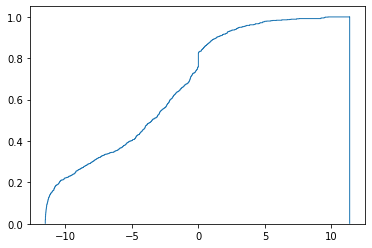

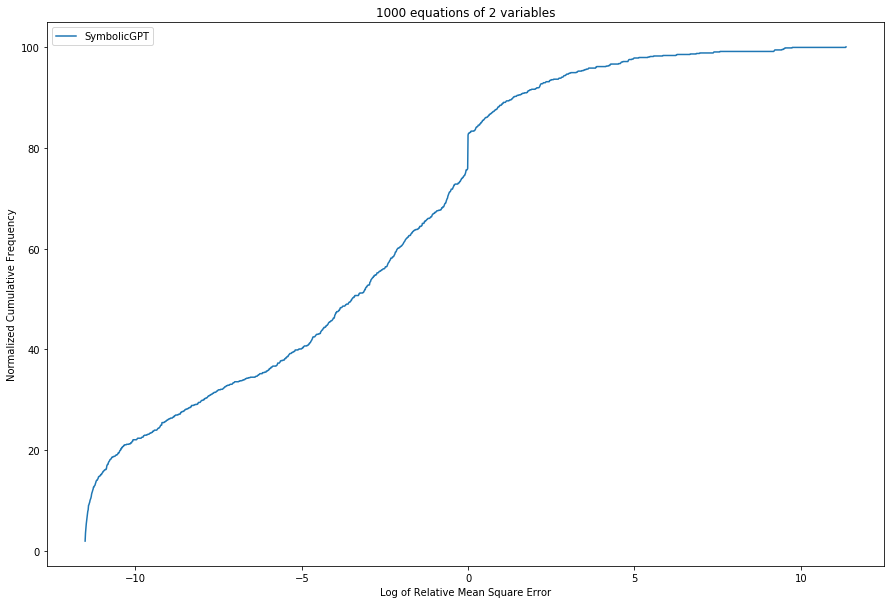

In [138]:
# plot the error frequency for model comparison
from matplotlib import pyplot as plt
num_eqns = len(resultDict[fName]['SymbolicGPT'])
num_vars = pconf.numberofVars

models = list(key for key in resultDict[fName].keys() if len(resultDict[fName][key])==num_eqns)
lists_of_error_scores = [resultDict[fName][key] for key in models if len(resultDict[fName][key])==num_eqns]
linestyles = ["-","dashdot","dotted","--"]

eps = 0.00001
y, x, _ = plt.hist([np.log([max(min(x+eps, 1e5),1e-5) for x in e]) for e in lists_of_error_scores],
                   label=models,
                   cumulative=True, 
                   histtype="step", 
                   bins=2000, 
                   density=True,
                   log=False)
y = np.expand_dims(y,0)
plt.figure(figsize=(15, 10))

for idx, m in enumerate(models): 
    plt.plot(x[:-1], 
           y[idx] * 100, 
           linestyle=linestyles[idx], 
           label=m)

plt.legend(loc="upper left")
plt.title("{} equations of {} variables".format(num_eqns, num_vars))
plt.xlabel("Log of Relative Mean Square Error")
plt.ylabel("Normalized Cumulative Frequency")

name = '{}.png'.format(fName.split('.txt')[0])
plt.savefig(name)

In [ ]:
# benchmarks